# DataDiagnostics - Development of a Diabetes Prediction Model using Machine Learning
#### Dataset source: https://www.kaggle.com/datasets/tigganeha4/diabetes-dataset-2019

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner

In [ ]:
%matplotlib inline
# Import necessary libraries

# Initial Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import tensorflow as tf
import keras_tuner as kt

In [ ]:
# Reinstall PySpark and Java to make sure everything is set up after the restart
!pip install -q pyspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Verify Java and PySpark installation
!java -version
!python -m pip show pyspark

# Initialize PySpark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Verify Spark version
print(f"Spark Version: {spark.version}")


openjdk version "11.0.24" 2024-07-16
OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04)
OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
Name: pyspark
Version: 3.5.3
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 
Spark Version: 3.5.3


In [ ]:
!pip install -q kaggle
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download dataset from Kaggle
!kaggle datasets download -d tigganeha4/diabetes-dataset-2019

# Unzip the dataset
!unzip -o diabetes-dataset-2019.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/tigganeha4/diabetes-dataset-2019
License(s): Attribution 4.0 International (CC BY 4.0)
diabetes-dataset-2019.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  diabetes-dataset-2019.zip
  inflating: diabetes_dataset__2019.csv  


In [ ]:
# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .getOrCreate()

# Load dataset into Spark DataFrame
df = spark.read.csv('diabetes_dataset__2019.csv', header=True, inferSchema=True)
df.show()

+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|         Age|Gender|Family_Diabetes|highBP|    PhysicallyActive|BMI|Smoking|Alcohol|Sleep|SoundSleep|RegularMedicine|    JunkFood|    Stress|BPLevel|Pregancies|Pdiabetes|UriationFreq|Diabetic|
+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|       50-59|  Male|             no|   yes|      one hr or more| 39|     no|     no|    8|       6.0|             no|occasionally| sometimes|   high|         0|        0|    not much|      no|
|       50-59|  Male|             no|   yes|less than half an hr| 28|     no|     no|    8|       6.0|            yes|  very often| sometimes| normal|         0|        0|    not much|      no|
|       40-49|  Male|         

In [ ]:
# Show schema to confirm date type
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Family_Diabetes: string (nullable = true)
 |-- highBP: string (nullable = true)
 |-- PhysicallyActive: string (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Sleep: integer (nullable = true)
 |-- SoundSleep: double (nullable = true)
 |-- RegularMedicine: string (nullable = true)
 |-- JunkFood: string (nullable = true)
 |-- Stress: string (nullable = true)
 |-- BPLevel: string (nullable = true)
 |-- Pregancies: integer (nullable = true)
 |-- Pdiabetes: string (nullable = true)
 |-- UriationFreq: string (nullable = true)
 |-- Diabetic: string (nullable = true)



In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df = df.toPandas()

# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

# Set the option to display all columns
pd.options.display.max_columns = None

# Show the first few rows of the DataFrame
df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


# Data Preprocessing Steps

In [ ]:
# Spelling corrections
df = df.rename(columns={'Family_Diabetes': 'FamilyDiabetes', 'Pregancies':'Pregnancies', 'Pdiabetes': 'GDiabetes', 'UriationFreq': 'UrinationFreq'})
df.head()

,Age,Gender,FamilyDiabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


In [ ]:
# Drop the column 'highBP'
df = df.copy()
df = df.drop(columns=['highBP'])
df.head()

,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,Male,no,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


In [ ]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Age                  0
Gender               0
FamilyDiabetes       0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregnancies         42
GDiabetes            1
UrinationFreq        0
Diabetic             1
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               952 non-null    object 
 1   Gender            952 non-null    object 
 2   FamilyDiabetes    952 non-null    object 
 3   PhysicallyActive  952 non-null    object 
 4   BMI               948 non-null    float64
 5   Smoking           952 non-null    object 
 6   Alcohol           952 non-null    object 
 7   Sleep             952 non-null    int32  
 8   SoundSleep        952 non-null    float64
 9   RegularMedicine   952 non-null    object 
 10  JunkFood          952 non-null    object 
 11  Stress            952 non-null    object 
 12  BPLevel           952 non-null    object 
 13  Pregnancies       910 non-null    float64
 14  GDiabetes         951 non-null    object 
 15  UrinationFreq     952 non-null    object 
 16  Diabetic          951 non-null    object 
dt

In [ ]:
# Drop rows with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               905 non-null    object 
 1   Gender            905 non-null    object 
 2   FamilyDiabetes    905 non-null    object 
 3   PhysicallyActive  905 non-null    object 
 4   BMI               905 non-null    float64
 5   Smoking           905 non-null    object 
 6   Alcohol           905 non-null    object 
 7   Sleep             905 non-null    int32  
 8   SoundSleep        905 non-null    float64
 9   RegularMedicine   905 non-null    object 
 10  JunkFood          905 non-null    object 
 11  Stress            905 non-null    object 
 12  BPLevel           905 non-null    object 
 13  Pregnancies       905 non-null    float64
 14  GDiabetes         905 non-null    object 
 15  UrinationFreq     905 non-null    object 
 16  Diabetic          905 non-null    object 
dtypes:

In [ ]:
# Display summary statistics of numerical columns
df.describe().round()

,BMI,Sleep,SoundSleep,Pregnancies
count,905.0,905.0,905.0,905.0
mean,26.0,7.0,6.0,0.0
std,5.0,1.0,2.0,1.0
min,15.0,4.0,0.0,0.0
25%,22.0,6.0,4.0,0.0
50%,24.0,7.0,6.0,0.0
75%,28.0,8.0,7.0,0.0
max,45.0,11.0,11.0,4.0


# Compute the correlation matrix on the entire DataFrame

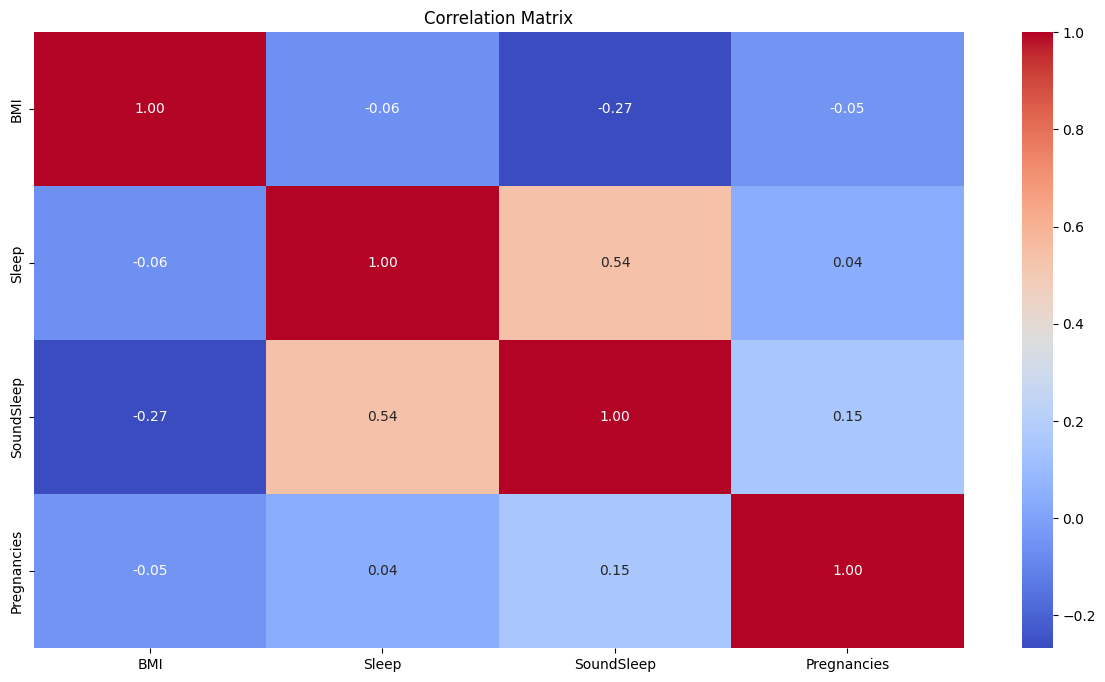

In [ ]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix on the numeric DataFrame
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# For binary categorical variables, convert 'yes' to 1 and 'no' to 0

In [ ]:
# Print the counts of unique values in the 'Gender' column
print(df['Gender'].value_counts())

# Print the counts of unique values in the 'FamilyDiabetes' column
print(df['FamilyDiabetes'].value_counts())

# Print the counts of unique values in the 'Smoking' column
print(df['Smoking'].value_counts())

# Print the counts of unique values in the 'Alcohol' column
print(df['Alcohol'].value_counts())

# Print the counts of unique values in the 'RegularMedicine' column
print(df['RegularMedicine'].value_counts())

# Print the counts of unique values in the 'Diabetic' column
print(df['Diabetic'].value_counts())

# Print the counts of unique values in the 'Gdiabetes' column
print(df['GDiabetes'].value_counts())

Gender
Male      562
Female    343
Name: count, dtype: int64
FamilyDiabetes
no     472
yes    433
Name: count, dtype: int64
Smoking
no     799
yes    106
Name: count, dtype: int64
Alcohol
no     718
yes    187
Name: count, dtype: int64
RegularMedicine
no     581
yes    323
o        1
Name: count, dtype: int64
Diabetic
no     641
yes    263
 no      1
Name: count, dtype: int64
GDiabetes
0      891
yes     14
Name: count, dtype: int64


In [ ]:
# Convert 'yes' to 1 and 'no' to 0 for binary categorical variables
binary_cols = ['FamilyDiabetes', 'Smoking', 'Alcohol']
for col in binary_cols:
    df[col] = df[col].str.strip().str.lower().map({'no': 0, 'yes': 1})

# Convert 'o' in 'RegularMedicine' to 0, handle NaNs if any
df['RegularMedicine'] = df['RegularMedicine'].map({'no': 0, 'yes': 1, 'o': 0}).fillna(0)

# Convert 'no' to 0 and 'yes' to 1 in 'Diabetic', handling extra spaces and missing values
df['Diabetic'] = df['Diabetic'].str.strip().map({'no': 0, 'yes': 1})

# Convert '0' to 0 and 'yes' to 1 in 'GDiabetes'
df['GDiabetes'] = df['GDiabetes'].map({'0': 0, 'yes': 1}).fillna(0)

# Convert 'Male' to 0 and 'Female' to 1 in 'Gender'
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Check for any remaining missing values
print(df.isnull().sum())

# Display the DataFrame head to inspect the changes
df.head()


Age                 0
Gender              0
FamilyDiabetes      0
PhysicallyActive    0
BMI                 0
Smoking             0
Alcohol             0
Sleep               0
SoundSleep          0
RegularMedicine     0
JunkFood            0
Stress              0
BPLevel             0
Pregnancies         0
GDiabetes           0
UrinationFreq       0
Diabetic            0
dtype: int64


,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,0,0,one hr or more,39.0,0,0,8,6.0,0,occasionally,sometimes,high,0.0,0,not much,0
1,50-59,0,0,less than half an hr,28.0,0,0,8,6.0,1,very often,sometimes,normal,0.0,0,not much,0
2,40-49,0,0,one hr or more,24.0,0,0,6,6.0,0,occasionally,sometimes,normal,0.0,0,not much,0
3,50-59,0,0,one hr or more,23.0,0,0,8,6.0,0,occasionally,sometimes,normal,0.0,0,not much,0
4,40-49,0,0,less than half an hr,27.0,0,0,8,8.0,0,occasionally,sometimes,normal,0.0,0,not much,0


In [ ]:
# Print the counts of unique values in the 'Gender' column
print(df['Gender'].value_counts())

# Print the counts of unique values in the 'FamilyDiabetes' column
print(df['FamilyDiabetes'].value_counts())

# Print the counts of unique values in the 'Smoking' column
print(df['Smoking'].value_counts())

# Print the counts of unique values in the 'Alcohol' column
print(df['Alcohol'].value_counts())

# Print the counts of unique values in the 'RegularMedicine' column
print(df['RegularMedicine'].value_counts())

# Print the counts of unique values in the 'Diabetic' column
print(df['Diabetic'].value_counts())

# Print the counts of unique values in the 'GDiabetes' column
print(df['GDiabetes'].value_counts())

Gender
0    562
1    343
Name: count, dtype: int64
FamilyDiabetes
0    472
1    433
Name: count, dtype: int64
Smoking
0    799
1    106
Name: count, dtype: int64
Alcohol
0    718
1    187
Name: count, dtype: int64
RegularMedicine
0    582
1    323
Name: count, dtype: int64
Diabetic
0    642
1    263
Name: count, dtype: int64
GDiabetes
0    891
1     14
Name: count, dtype: int64


In [ ]:
# One-hot encode the nominal categorical columns
nominal_cols = ['Gender', 'FamilyDiabetes', 'Smoking', 'Alcohol', 'RegularMedicine', 'Diabetic', 'GDiabetes']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Convert boolean columns (if any) to integer (0/1)
# Only apply astype(int) to the newly created one-hot encoded columns
# This ignores other columns like 'Age' which are non-numeric.
for col in df.columns:
    if df[col].dtype == 'bool':  # Check for boolean dtype
        df[col] = df[col].astype(int)

# Display the DataFrame head to inspect the changes
df.head()


,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregnancies,UrinationFreq,Gender_1,FamilyDiabetes_1,Smoking_1,Alcohol_1,RegularMedicine_1,Diabetic_1,GDiabetes_1
0,50-59,one hr or more,39.0,8,6.0,occasionally,sometimes,high,0.0,not much,0,0,0,0,0,0,0
1,50-59,less than half an hr,28.0,8,6.0,very often,sometimes,normal,0.0,not much,0,0,0,0,1,0,0
2,40-49,one hr or more,24.0,6,6.0,occasionally,sometimes,normal,0.0,not much,0,0,0,0,0,0,0
3,50-59,one hr or more,23.0,8,6.0,occasionally,sometimes,normal,0.0,not much,0,0,0,0,0,0,0
4,40-49,less than half an hr,27.0,8,8.0,occasionally,sometimes,normal,0.0,not much,0,0,0,0,0,0,0


In [ ]:
# Print the counts of unique values in the 'Age' column
print(df['Age'].value_counts())

# Print the counts of unique values in the 'PhysicallyActive' column
print(df['PhysicallyActive'].value_counts())

# Print the counts of unique values in the 'JunkFood' column
print(df['JunkFood'].value_counts())

# Print the counts of unique values in the 'Stress' column
print(df['Stress'].value_counts())

# Print the counts of unique values in the 'BPLevel' column
print(df['BPLevel'].value_counts())

# Print the counts of unique values in the 'UrinationFreq' column
print(df['UrinationFreq'].value_counts())

Age
less than 40    462
40-49           153
50-59           148
60 or older     142
Name: count, dtype: int64
PhysicallyActive
less than half an hr    317
more than half an hr    251
one hr or more          208
none                    129
Name: count, dtype: int64
JunkFood
occasionally    633
often           176
very often       52
always           44
Name: count, dtype: int64
Stress
sometimes     530
very often    158
not at all    131
always         86
Name: count, dtype: int64
BPLevel
normal     667
high       205
low         25
High         5
Low          2
normal       1
Name: count, dtype: int64
UrinationFreq
not much       642
quite often    263
Name: count, dtype: int64


In [ ]:
# Ordinal encoding for 'Age'
df['Age'] = df['Age'].map({'less than 40': 0, '40-49': 1, '50-59': 2, '60 or older': 3})

# Ordinal encoding for 'PhysicallyActive'
df['PhysicallyActive'] = df['PhysicallyActive'].map({
    'none': 0,
    'less than half an hr': 1,
    'more than half an hr': 2,
    'one hr or more': 3
})

# Ordinal encoding for 'JunkFood'
df['JunkFood'] = df['JunkFood'].map({
    'occasionally': 0,
    'often': 1,
    'very often': 2,
    'always': 3
})

# Ordinal encoding for 'Stress'
df['Stress'] = df['Stress'].map({
    'not at all': 0,
    'sometimes': 1,
    'very often': 2,
    'always': 3
})

# Ordinal encoding for 'BPLevel'
df['BPLevel'] = df['BPLevel'].str.strip().str.lower().map({
    'low': 0,
    'normal': 1,
    'high': 2
})

# Ordinal encoding for 'UrinationFreq'
df['UrinationFreq'] = df['UrinationFreq'].map({
    'not much': 0,
    'quite often': 1
})

# Display the DataFrame head to inspect the changes
df.head()


,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregnancies,UrinationFreq,Gender_1,FamilyDiabetes_1,Smoking_1,Alcohol_1,RegularMedicine_1,Diabetic_1,GDiabetes_1
0,2,3,39.0,8,6.0,0,1,2,0.0,0,0,0,0,0,0,0,0
1,2,1,28.0,8,6.0,2,1,1,0.0,0,0,0,0,0,1,0,0
2,1,3,24.0,6,6.0,0,1,1,0.0,0,0,0,0,0,0,0,0
3,2,3,23.0,8,6.0,0,1,1,0.0,0,0,0,0,0,0,0,0
4,1,1,27.0,8,8.0,0,1,1,0.0,0,0,0,0,0,0,0,0


In [ ]:
# Print the counts of unique values for the 'Age' column after mapping categorical ordinal values to numerical values
print(df['Age'].value_counts())

# Print the counts of unique values for the 'PhysicallyActive' column after mapping categorical ordinal values to numerical values
print(df['PhysicallyActive'].value_counts())

# Print the counts of unique values for the 'JunkFood' column after mapping categorical ordinal values to numerical values
print(df['JunkFood'].value_counts())

# Print the counts of unique values for the 'Stress' column after mapping categorical ordinal values to numerical values
print(df['Stress'].value_counts())

# Print the counts of unique values for the 'BPLevel' column after mapping categorical ordinal values to numerical values
print(df['BPLevel'].value_counts())

# Print the counts of unique values for the 'UrinationFreq' column after mapping categorical ordinal values to numerical values
print(df['UrinationFreq'].value_counts())

Age
0    462
1    153
2    148
3    142
Name: count, dtype: int64
PhysicallyActive
1    317
2    251
3    208
0    129
Name: count, dtype: int64
JunkFood
0    633
1    176
2     52
3     44
Name: count, dtype: int64
Stress
1    530
2    158
0    131
3     86
Name: count, dtype: int64
BPLevel
1    668
2    210
0     27
Name: count, dtype: int64
UrinationFreq
0    642
1    263
Name: count, dtype: int64


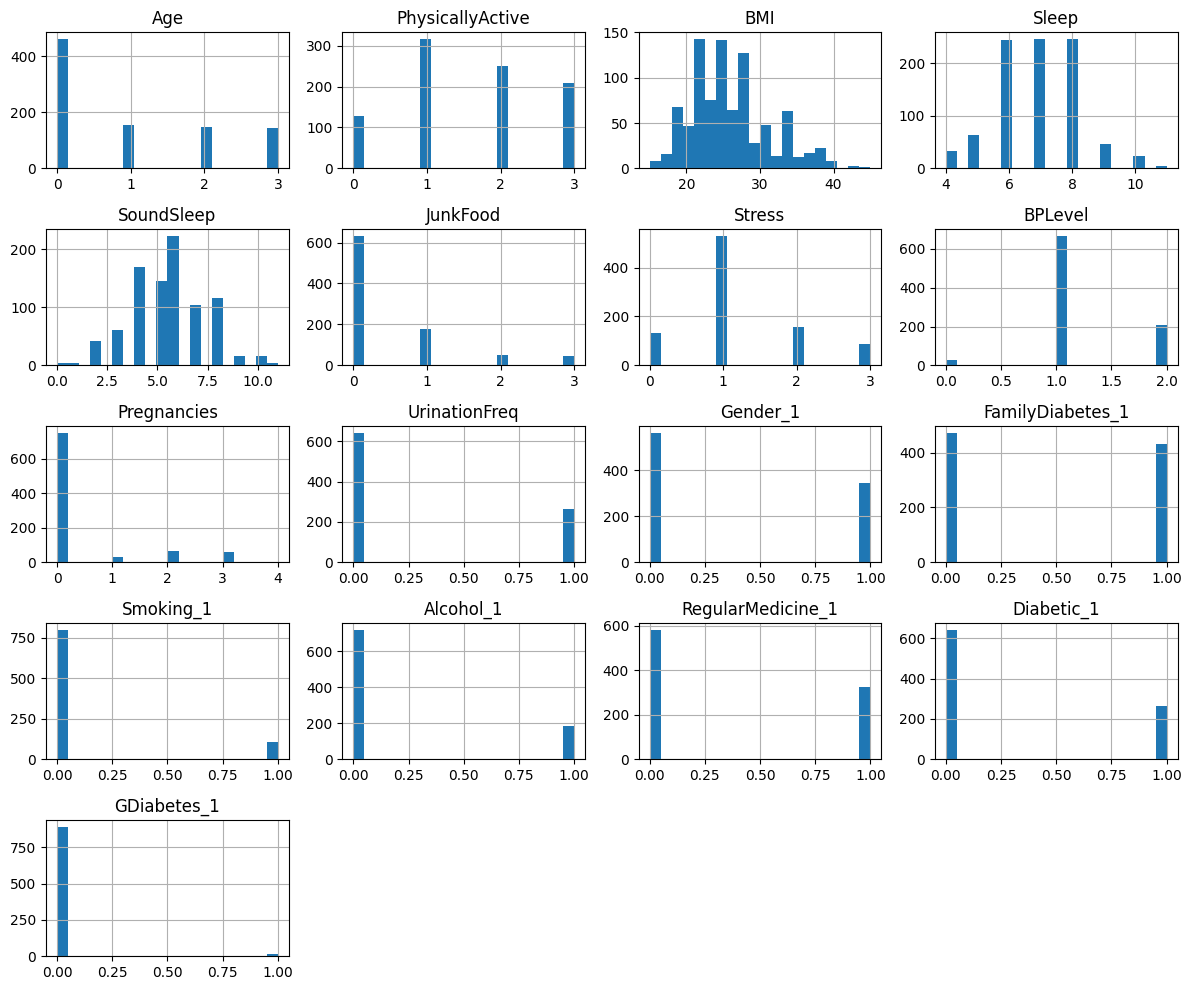

In [ ]:
# Explore distributions of numerical variables using histograms
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [ ]:
# Print the data types of columns in the DataFrame
df.dtypes

,0
Age,int64
PhysicallyActive,int64
BMI,float64
Sleep,int32
SoundSleep,float64
JunkFood,int64
Stress,int64
BPLevel,int64
Pregnancies,float64
UrinationFreq,int64


In [ ]:
# Convert SoundSleep and Pregnancies to integers
df['SoundSleep'] = df['SoundSleep'].fillna(0).astype(int)
df['Pregnancies'] = df['Pregnancies'].fillna(0).astype(int)
df['BMI'] = df['BMI'].fillna(0).astype(int)

In [ ]:
# Print the data types of columns in the DataFrame
df.dtypes

,0
Age,int64
PhysicallyActive,int64
BMI,int64
Sleep,int32
SoundSleep,int64
JunkFood,int64
Stress,int64
BPLevel,int64
Pregnancies,int64
UrinationFreq,int64


In [ ]:
# Display the first few rows of the DataFrame to inspect the data
df.head()

,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregnancies,UrinationFreq,Gender_1,FamilyDiabetes_1,Smoking_1,Alcohol_1,RegularMedicine_1,Diabetic_1,GDiabetes_1
0,2,3,39,8,6,0,1,2,0,0,0,0,0,0,0,0,0
1,2,1,28,8,6,2,1,1,0,0,0,0,0,0,1,0,0
2,1,3,24,6,6,0,1,1,0,0,0,0,0,0,0,0,0
3,2,3,23,8,6,0,1,1,0,0,0,0,0,0,0,0,0
4,1,1,27,8,8,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Rename the columns
df.rename(columns={
    'PhysicallyActive': 'PhysicalActivityLevel',
    'JunkFood': 'JunkFoodFrequency',
    'Stress': 'StressLevel',
    'BPLevel': 'BloodPressureLevel',
    'UrinationFreq': 'UrinationFrequency',
    'Gender_1': 'Gender',  # Change to 'Gender' as requested
    'FamilyDiabetes_1': 'FamilyDiabetes',
    'Smoking_1': 'Smoking',
    'Alcohol_1': 'AlcoholConsumption',
    'RegularMedicine_1': 'RegularMedicineUse',
    'Diabetic_1': 'Diabetic',
    'GDiabetes_1': 'GestationalDiabetes'
}, inplace=True)

# Display the updated DataFrame column names
print(df.columns)


Index(['Age', 'PhysicalActivityLevel', 'BMI', 'Sleep', 'SoundSleep',
       'JunkFoodFrequency', 'StressLevel', 'BloodPressureLevel', 'Pregnancies',
       'UrinationFrequency', 'Gender', 'FamilyDiabetes', 'Smoking',
       'AlcoholConsumption', 'RegularMedicineUse', 'Diabetic',
       'GestationalDiabetes'],
      dtype='object')


In [ ]:
df.head()

,Age,PhysicalActivityLevel,BMI,Sleep,SoundSleep,JunkFoodFrequency,StressLevel,BloodPressureLevel,Pregnancies,UrinationFrequency,Gender,FamilyDiabetes,Smoking,AlcoholConsumption,RegularMedicineUse,Diabetic,GestationalDiabetes
0,2,3,39,8,6,0,1,2,0,0,0,0,0,0,0,0,0
1,2,1,28,8,6,2,1,1,0,0,0,0,0,0,1,0,0
2,1,3,24,6,6,0,1,1,0,0,0,0,0,0,0,0,0
3,2,3,23,8,6,0,1,1,0,0,0,0,0,0,0,0,0
4,1,1,27,8,8,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Export processed DataFrame to a CSV file
df.to_csv("processed_dataset.csv")

In [ ]:
# Extract the target variable (binary classification)
y = df['Diabetic'].values  # No need for reshaping or one-hot encoding

# Check the shape of y
print(y.shape)

(905,)


# Target and Feature Variables

In [ ]:
# Split the data into features (X) and target variable (y)
X = df.drop('Diabetic', axis=1)  # Features
y = df["Diabetic"].values  # Target (no need to reshape or ravel)


In [ ]:
# Display the processed DataFrame
print("\nProcessed DataFrame:")
X.head()


Processed DataFrame:


,Age,PhysicalActivityLevel,BMI,Sleep,SoundSleep,JunkFoodFrequency,StressLevel,BloodPressureLevel,Pregnancies,UrinationFrequency,Gender,FamilyDiabetes,Smoking,AlcoholConsumption,RegularMedicineUse,GestationalDiabetes
0,2,3,39,8,6,0,1,2,0,0,0,0,0,0,0,0
1,2,1,28,8,6,2,1,1,0,0,0,0,0,0,1,0
2,1,3,24,6,6,0,1,1,0,0,0,0,0,0,0,0
3,2,3,23,8,6,0,1,1,0,0,0,0,0,0,0,0
4,1,1,27,8,8,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
print("\nTarget variable:")
y[:5]


Target variable:


array([0, 0, 0, 0, 0])

## Training and testing of datasets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (do not fit on test data)
X_test_scaled = scaler.transform(X_test)

# Check the shape of the scaled data
print(X_train_scaled.shape, X_test_scaled.shape)


(724, 16) (181, 16)


## Logistic Regression Model

In [ ]:
# Creating the logistic regression instance
log_reg_model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1)

# Fitting the model
log_reg_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
log_reg_pred = log_reg_model.predict(X_test_scaled)

# Calculating the confusion matrix
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
log_reg_cm_df = pd.DataFrame(
    log_reg_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)

# Generating the classification report
log_reg_report = classification_report(y_test, log_reg_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True)

# Displaying results
print("Confusion Matrix:")
display(log_reg_cm_df)
print("-------------------------------------------")
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print("-------------------------------------------")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

# Store logistic regression results for future comparison
log_reg_results = {
    'Confusion Matrix': log_reg_cm_df,
    'Accuracy': log_reg_accuracy,
    'Classification Report': log_reg_report  # Using the generated report
}


Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,123,9
Diabetes Present,17,32


-------------------------------------------
Logistic Regression Accuracy: 0.8564
-------------------------------------------
Logistic Regression Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.88      0.93      0.90       132
Diabetes Present       0.78      0.65      0.71        49

        accuracy                           0.86       181
       macro avg       0.83      0.79      0.81       181
    weighted avg       0.85      0.86      0.85       181



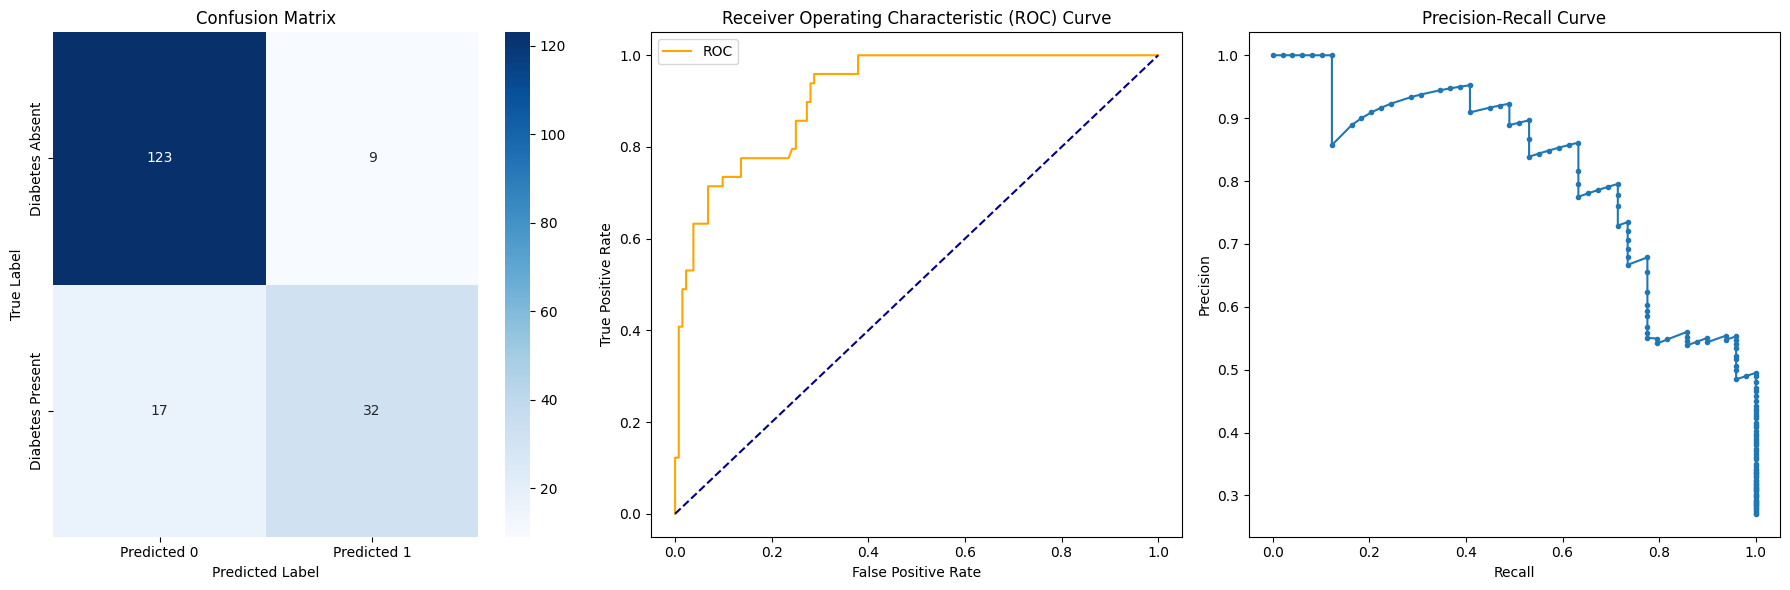

In [ ]:
# Making predictions and calculating probabilities using the testing data
log_reg_pred = log_reg_model.predict(X_test_scaled)  # Predictions
log_reg_probs = log_reg_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class (Diabetes Present)

# Calculating the confusion matrix
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
log_reg_cm_df = pd.DataFrame(
    log_reg_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(log_reg_cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, log_reg_probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, log_reg_probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


## Random Forest Model

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
rf_pred = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
rf_cm_df = pd.DataFrame(
    rf_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
rf_accuracy = accuracy_score(y_test, rf_pred)

# Generating the classification report
rf_report = classification_report(y_test, rf_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True)

# Displaying results
print("Random Forest Confusion Matrix:")
display(rf_cm_df)
print("-------------------------------------------")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("-------------------------------------------")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

# Store random forest results for future comparison
rf_results = {
    'Confusion Matrix': rf_cm_df,
    'Accuracy': rf_accuracy,
    'Classification Report': rf_report  # Using the generated report
}


Random Forest Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,129,3
Diabetes Present,4,45


-------------------------------------------
Random Forest Accuracy: 0.9613
-------------------------------------------
Random Forest Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.97      0.98      0.97       132
Diabetes Present       0.94      0.92      0.93        49

        accuracy                           0.96       181
       macro avg       0.95      0.95      0.95       181
    weighted avg       0.96      0.96      0.96       181



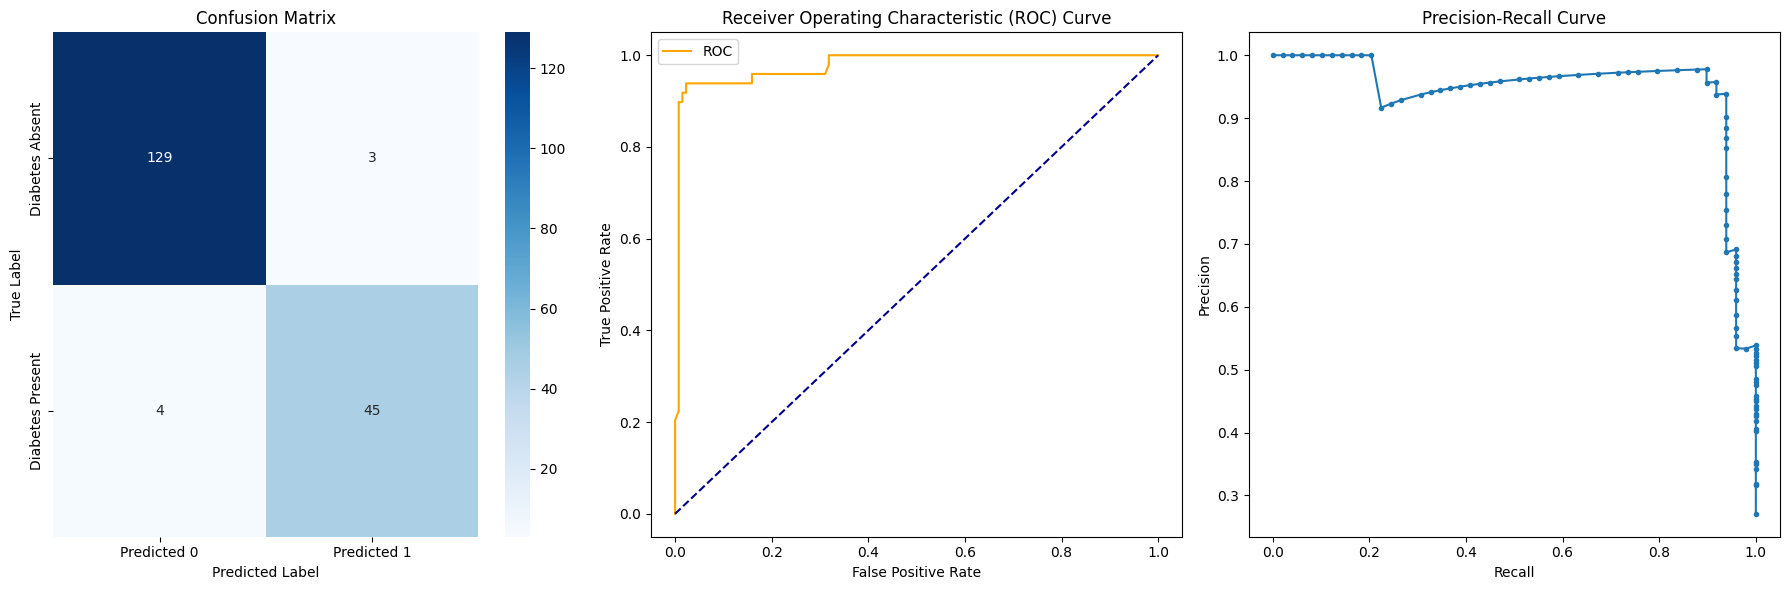

In [ ]:
# Making predictions and calculating probabilities using the testing data
predictions = rf_model.predict(X_test_scaled)
probs = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Feature Importances

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.22964275058606956, 'RegularMedicineUse'),
 (0.19266753017051688, 'Age'),
 (0.09689978569878255, 'BMI'),
 (0.07490513086191017, 'BloodPressureLevel'),
 (0.06579008364586574, 'SoundSleep'),
 (0.06107397255144265, 'StressLevel'),
 (0.051922425637089924, 'PhysicalActivityLevel'),
 (0.05006841307723099, 'Sleep'),
 (0.04880550435399358, 'FamilyDiabetes'),
 (0.030550662069774165, 'Pregnancies'),
 (0.021221101385679873, 'GestationalDiabetes'),
 (0.021196259009288114, 'JunkFoodFrequency'),
 (0.017137843776845425, 'UrinationFrequency'),
 (0.015656018795198495, 'AlcoholConsumption'),
 (0.015476910998442386, 'Gender'),
 (0.006985607381869371, 'Smoking')]

<Axes: title={'center': 'Feature Importances'}, ylabel='1'>

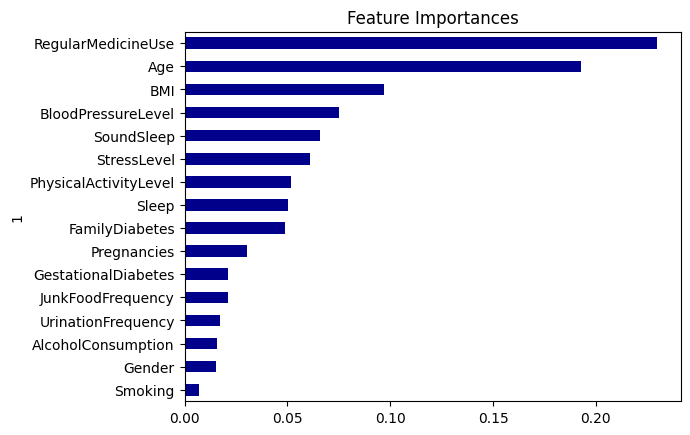

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='darkblue', title= 'Feature Importances', legend=False)

## Decision Tree Model

In [ ]:
# Creating the decision tree classifier instance
dt_model = DecisionTreeClassifier(random_state=1)

# Fitting the model
dt_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
dt_pred = dt_model.predict(X_test_scaled)

# Calculating the confusion matrix
dt_cm = confusion_matrix(y_test, dt_pred)
dt_cm_df = pd.DataFrame(
    dt_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
dt_accuracy = accuracy_score(y_test, dt_pred)

# Generating the classification report
dt_report = classification_report(y_test, dt_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True)

# Displaying results
print("Decision Tree Confusion Matrix:")
display(dt_cm_df)
print("-------------------------------------------")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print("-------------------------------------------")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

# Store decision tree results for future comparison
dt_results = {
    'Confusion Matrix': dt_cm_df,
    'Accuracy': dt_accuracy,
    'Classification Report': dt_report  # Using the generated report
}


Decision Tree Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,130,2
Diabetes Present,5,44


-------------------------------------------
Decision Tree Accuracy: 0.9613
-------------------------------------------
Decision Tree Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.96      0.98      0.97       132
Diabetes Present       0.96      0.90      0.93        49

        accuracy                           0.96       181
       macro avg       0.96      0.94      0.95       181
    weighted avg       0.96      0.96      0.96       181



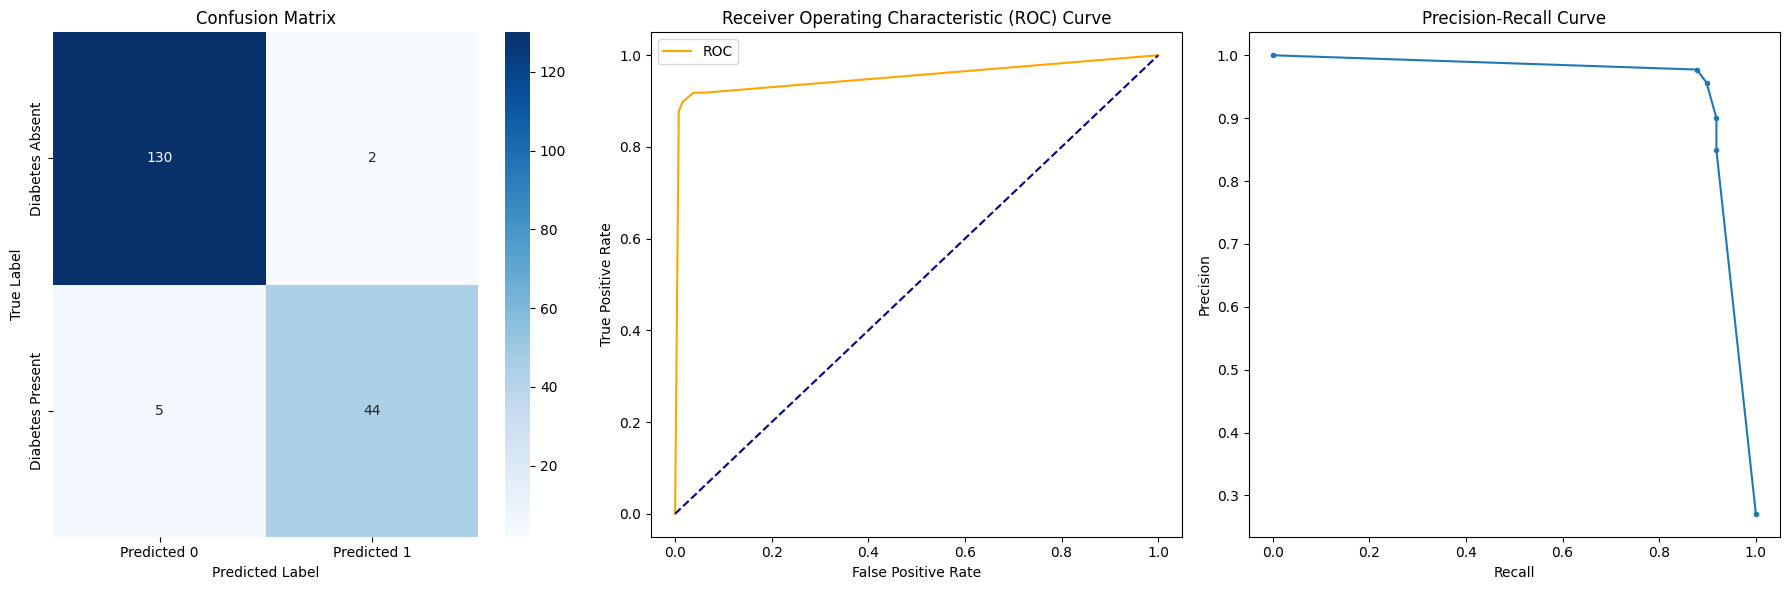

In [ ]:
# Making predictions using the testing data
predictions = dt_model.predict(X_test_scaled)
probs = dt_model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Support Vector Machine (SVM) Model

In [ ]:
# Creating the SVC classifier instance
svm_model = SVC(kernel='linear')

# Fitting the model
svm_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
svm_pred = svm_model.predict(X_test_scaled)

# Calculating the confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred)
svm_cm_df = pd.DataFrame(
    svm_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
svm_accuracy = accuracy_score(y_test, svm_pred)

# Generating the classification report
svm_report = classification_report(y_test, svm_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True)

# Displaying results
print("SVM Confusion Matrix:")
display(svm_cm_df)
print("-------------------------------------------")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("-------------------------------------------")
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

# Store SVM results for future comparison
svm_results = {
    'Confusion Matrix': svm_cm_df,
    'Accuracy': svm_accuracy,
    'Classification Report': svm_report  # Using the generated report
}


SVM Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,123,9
Diabetes Present,14,35


-------------------------------------------
SVM Accuracy: 0.8729
-------------------------------------------
SVM Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.90      0.93      0.91       132
Diabetes Present       0.80      0.71      0.75        49

        accuracy                           0.87       181
       macro avg       0.85      0.82      0.83       181
    weighted avg       0.87      0.87      0.87       181



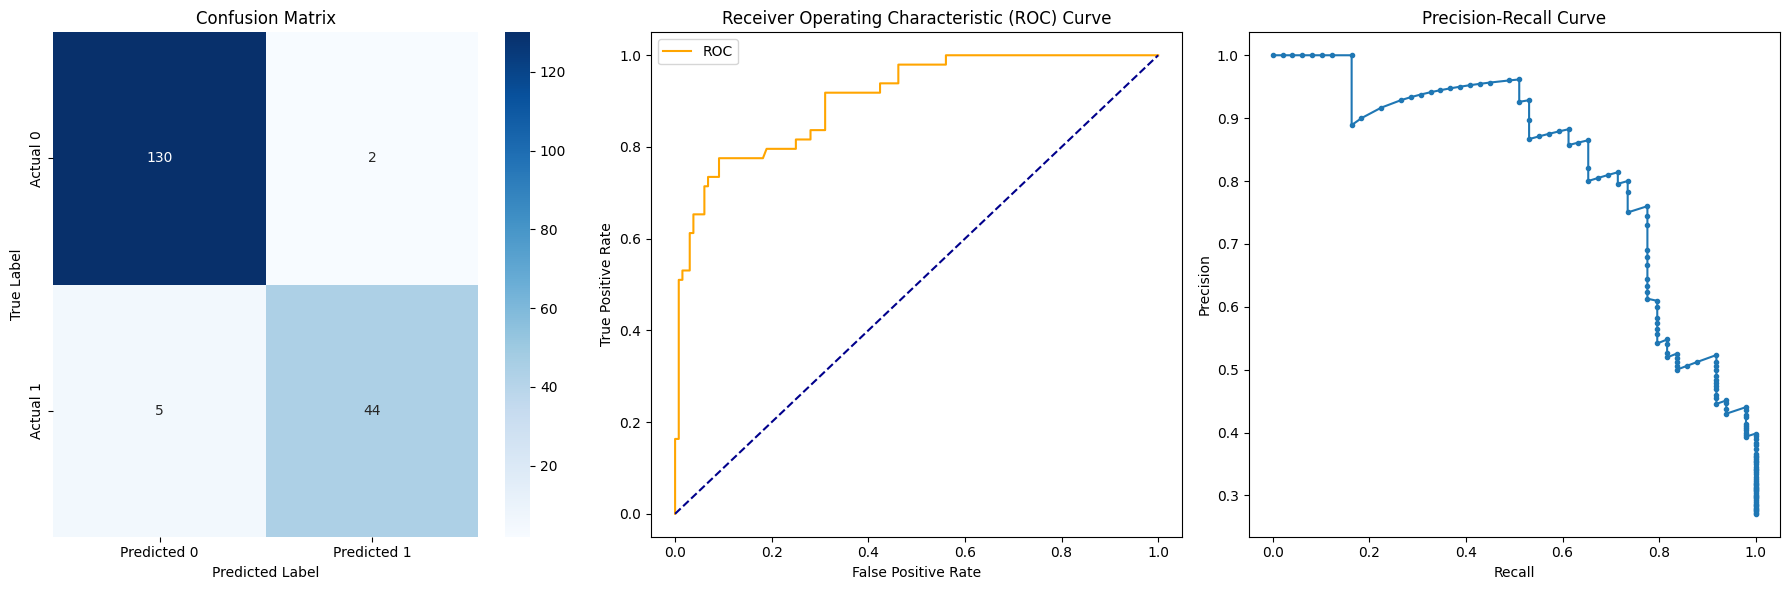

In [ ]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = svm_model .decision_function(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## K-Nearest Neighbors (KNN) Model

In [ ]:
# Creating the KNN classifier instance
knn_model = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
knn_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
knn_pred = knn_model.predict(X_test_scaled)

# Calculating the confusion matrix
knn_cm = confusion_matrix(y_test, knn_pred)
knn_cm_df = pd.DataFrame(
    knn_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
knn_accuracy = accuracy_score(y_test, knn_pred)

# Generating the classification report
knn_report = classification_report(y_test, knn_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True)

# Displaying results
print("KNN Confusion Matrix:")
display(knn_cm_df)
print("-------------------------------------------")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print("-------------------------------------------")
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

# Store KNN results for future comparison
knn_results = {
    'Confusion Matrix': knn_cm_df,
    'Accuracy': knn_accuracy,
    'Classification Report': knn_report  # Using the generated report
}


KNN Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,129,3
Diabetes Present,4,45


-------------------------------------------
KNN Accuracy: 0.9613
-------------------------------------------
KNN Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.97      0.98      0.97       132
Diabetes Present       0.94      0.92      0.93        49

        accuracy                           0.96       181
       macro avg       0.95      0.95      0.95       181
    weighted avg       0.96      0.96      0.96       181



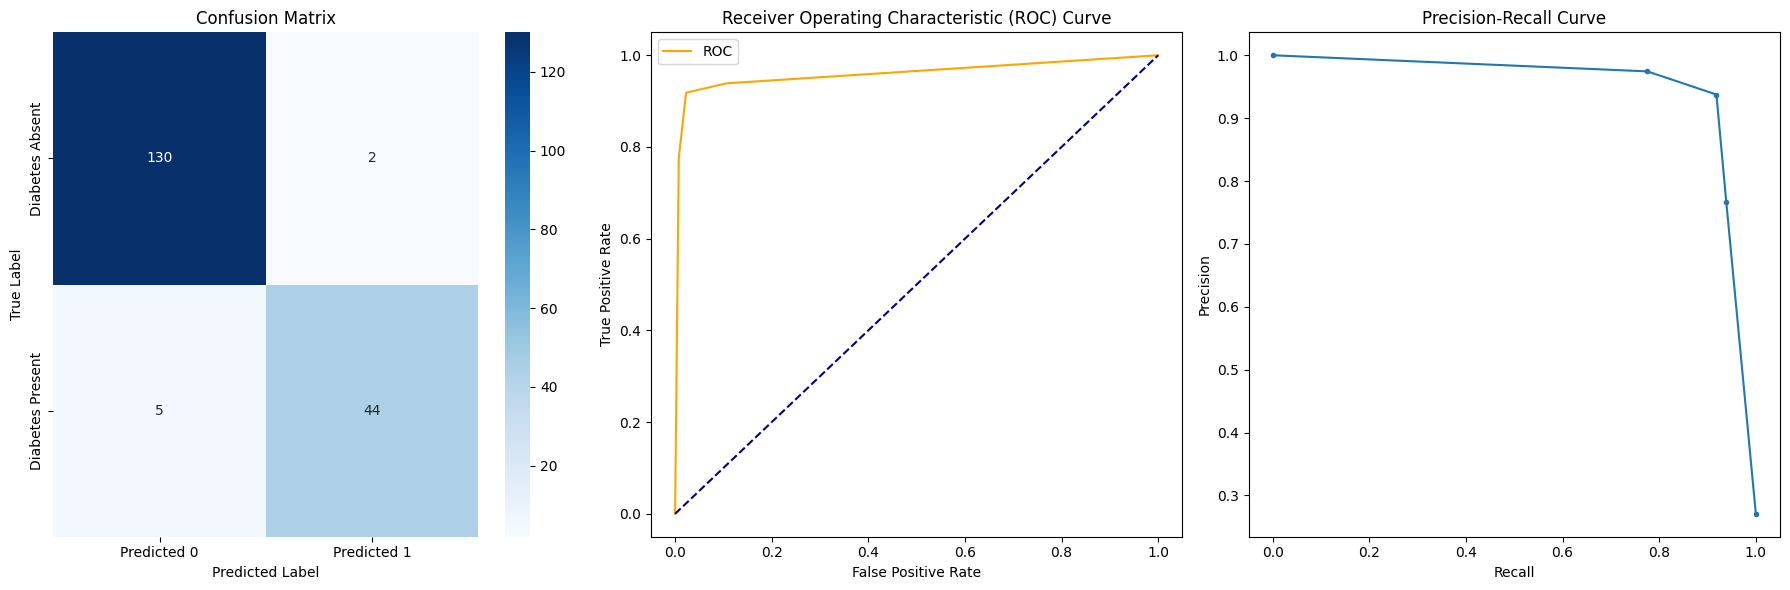

In [ ]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Neural Network Model

Step 1: Import Libraries

In [ ]:
# Import necessary libraries
import tensorflow as tf  # Add this line
import keras_tuner as kt  # Shortened import for keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Initial train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Confirm the shape of X_train_scaled
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")

# Ensure input_shape is correctly set
input_shape = X_train_scaled.shape[1]  # This should be the number of features (16 in your case)
print(f"Input shape: {input_shape}")


Shape of X_train_scaled: (579, 16)
Input shape: 16


Step 2: Define Model Building Function Using Keras Tuner (Hyperparameter Tuning)

In [ ]:
# Define the input shape based on the number of features in X_train_resampled_scaled
input_shape = X_train_scaled.shape[1]

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    # First layer
    model.add(Dense(
        units=hp.Int('input_units', min_value=32, max_value=512, step=32),
        activation=hp.Choice('input_activation', values=['relu', 'tanh', 'selu', 'elu']),
        input_shape=(input_shape,)
    ))
    model.add(Dropout(
        hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
    ))

    # Additional layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'selu', 'elu'])
        ))
        model.add(Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.05)
        ))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


Step 3: Initialize and Run the Hyperband Tuner

In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_logs',
    project_name='diabetes_prediction'
)


Reloading Tuner from keras_tuner_logs/diabetes_prediction/tuner0.json


In [ ]:
# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), verbose=1)



In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Print the best hyperparameters
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'input_units': 160, 'dropout': 0.2, 'num_layers': 3, 'activation_0': 'relu', 'units_0': 448, 'dropout_0': 0.2, 'learning_rate': 0.001, 'activation_1': 'tanh', 'units_1': 224, 'dropout_1': 0.30000000000000004, 'activation_2': 'tanh', 'units_2': 128, 'dropout_2': 0.4, 'activation_3': 'tanh', 'units_3': 352, 'dropout_3': 0.2, 'activation_4': 'tanh', 'units_4': 224, 'dropout_4': 0.30000000000000004, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}


Step 5: The Best Model in .keras Format

In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model on the full training data (including validation set)
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=27,  # Set a high number for potential early stopping
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7660 - loss: 0.5442 - val_accuracy: 0.8690 - val_loss: 0.3146
Epoch 2/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8458 - loss: 0.3296 - val_accuracy: 0.8828 - val_loss: 0.2577
Epoch 3/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8960 - loss: 0.2450 - val_accuracy: 0.9034 - val_loss: 0.2223
Epoch 4/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9084 - loss: 0.2179 - val_accuracy: 0.9379 - val_loss: 0.2235
Epoch 5/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9335 - loss: 0.1742 - val_accuracy: 0.8966 - val_loss: 0.2559
Epoch 6/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9051 - loss: 0.2196 - val_accuracy: 0.9241 - val_loss: 0.2151
Epoch 7/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9109 - loss: 0.1882 - val_accuracy: 0.9103 - val_loss: 0.2488
Epoch 8/27
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9206 - loss: 0.2140 - val_accuracy: 0.9241 - v

Evaluating the Model

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9586 - loss: 0.1655 
Test Accuracy: 0.9724


Save the Best Model

In [ ]:
best_model.save("best_model.keras")

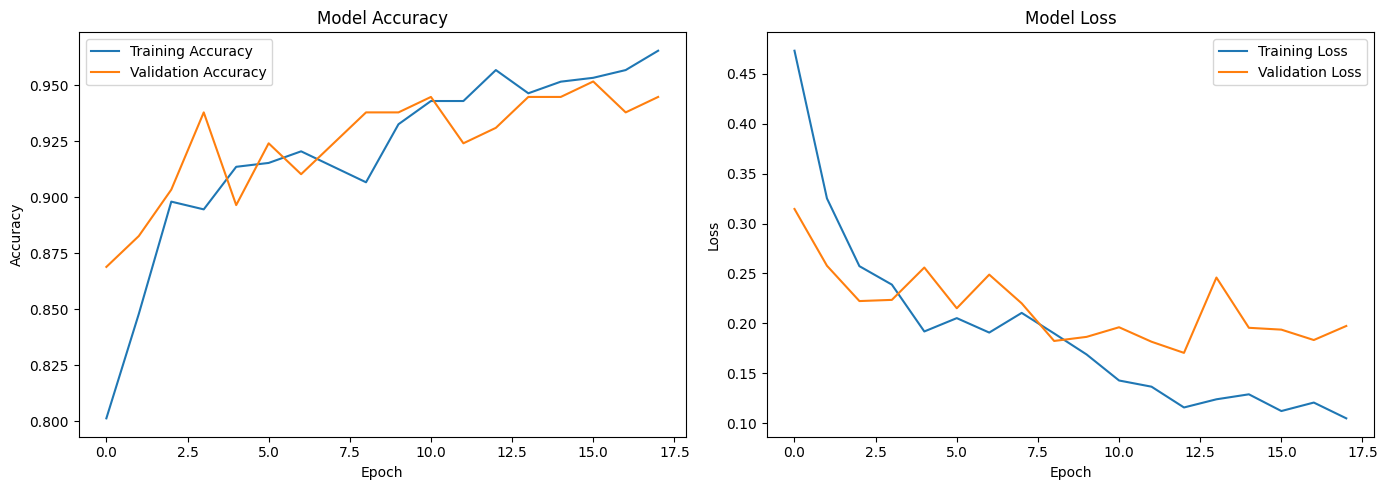

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


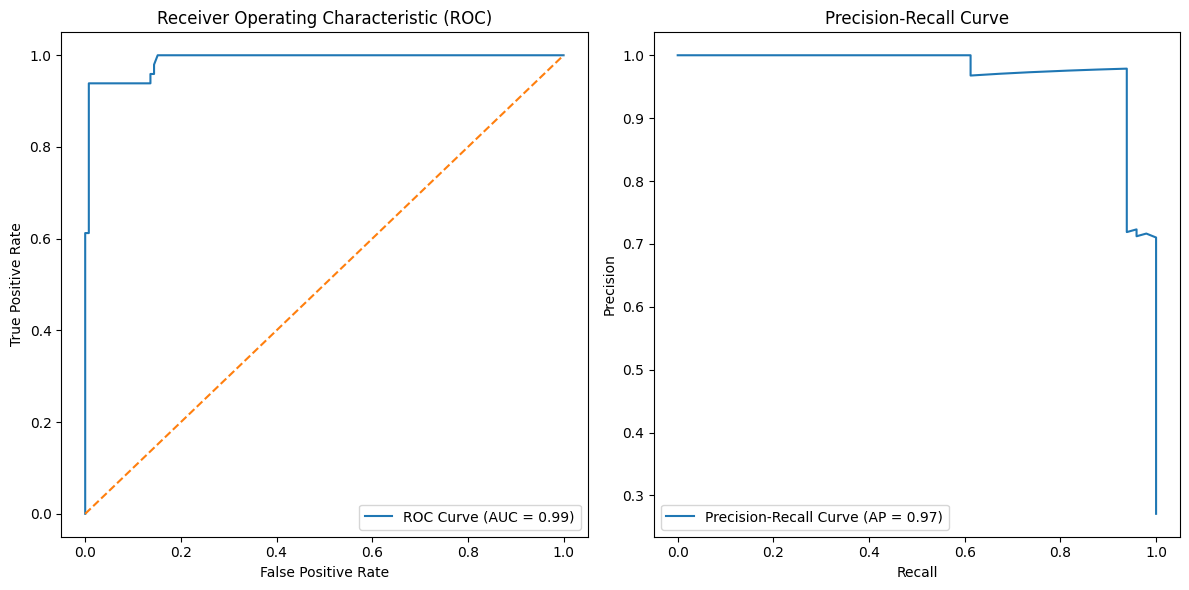

Optimal Threshold: 0.78


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import matplotlib.pyplot as plt

# Generate predicted probabilities on the test data
y_pred_probs = best_model.predict(X_test_scaled).flatten()

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(12, 6))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)
average_precision = average_precision_score(y_test, y_pred_probs)

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Calculate the index where the difference between tpr and fpr is maximized
optimal_idx = np.argmax(tpr - fpr)

# Ensure optimal_idx is within the bounds of the thresholds array
optimal_idx = min(optimal_idx, len(thresholds) - 1)

# Retrieve the optimal threshold
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.2f}')


In [ ]:
import numpy as np

nn_pred_probs = best_model.predict(X_test_scaled)
nn_pred = (nn_pred_probs > 0.5).astype("int32")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Compute Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
nn_cm = confusion_matrix(y_test, nn_pred)
nn_cm_df = pd.DataFrame(
    nn_cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Classification Report
nn_classification_report = classification_report(
    y_test, nn_pred, target_names=["Diabetes Absent", "Diabetes Present"], output_dict=True
)


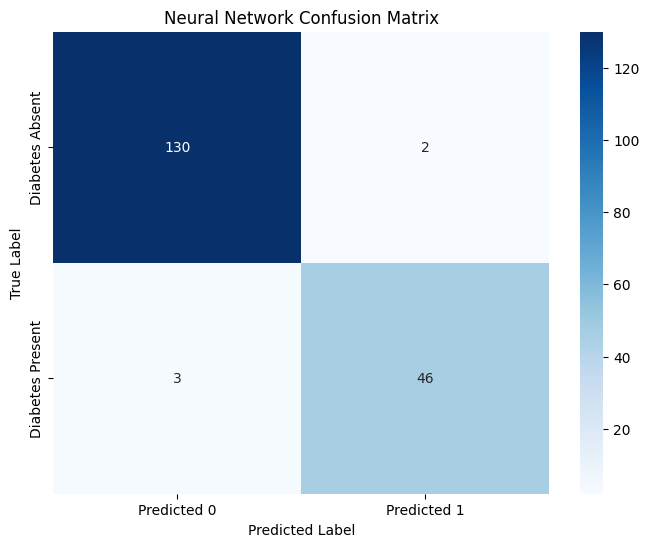

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(nn_cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

nn_accuracy = accuracy_score(y_test, nn_pred)

print("Neural Network Confusion Matrix:")
print(nn_cm_df)
print("-------------------------------------------")
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
print("-------------------------------------------")
print("Neural Network Classification Report:")
print(classification_report(y_test, nn_pred, target_names=["Diabetes Absent", "Diabetes Present"]))


Neural Network Confusion Matrix:
                  Predicted 0  Predicted 1
Diabetes Absent           130            2
Diabetes Present            3           46
-------------------------------------------
Neural Network Accuracy: 0.9724
-------------------------------------------
Neural Network Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.98      0.98      0.98       132
Diabetes Present       0.96      0.94      0.95        49

        accuracy                           0.97       181
       macro avg       0.97      0.96      0.96       181
    weighted avg       0.97      0.97      0.97       181



In [ ]:
# Store Results for Comparison
nn_results = {
    'Confusion Matrix': nn_cm_df,
    'Accuracy': nn_accuracy,
    'Classification Report': nn_classification_report
}


In [ ]:
# Assuming you have already evaluated the models and stored their results


# Create a summary DataFrame for comparison
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest", "Support Vector Machine", "K-Nearest Neighbors", "Decision Tree", "Neural Network"],
    "Accuracy": [
        log_reg_results['Accuracy'],
        rf_results['Accuracy'],
        svm_results['Accuracy'],
        knn_results['Accuracy'],
        dt_results['Accuracy'],
        nn_results['Accuracy']
    ],
    "Precision": [
        log_reg_results['Classification Report']['Diabetes Present']['precision'],
        rf_results['Classification Report']['Diabetes Present']['precision'],
        svm_results['Classification Report']['Diabetes Present']['precision'],
        knn_results['Classification Report']['Diabetes Present']['precision'],
        dt_results['Classification Report']['Diabetes Present']['precision'],
        nn_results['Classification Report']['Diabetes Present']['precision']
    ],
    "Recall": [
        log_reg_results['Classification Report']['Diabetes Present']['recall'],
        rf_results['Classification Report']['Diabetes Present']['recall'],
        svm_results['Classification Report']['Diabetes Present']['recall'],
        knn_results['Classification Report']['Diabetes Present']['recall'],
        dt_results['Classification Report']['Diabetes Present']['recall'],
        nn_results['Classification Report']['Diabetes Present']['recall']
    ],
    "F1-Score": [
        log_reg_results['Classification Report']['Diabetes Present']['f1-score'],
        rf_results['Classification Report']['Diabetes Present']['f1-score'],
        svm_results['Classification Report']['Diabetes Present']['f1-score'],
        knn_results['Classification Report']['Diabetes Present']['f1-score'],
        dt_results['Classification Report']['Diabetes Present']['f1-score'],
        nn_results['Classification Report']['Diabetes Present']['f1-score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)


Model Comparison (Accuracy, Precision, Recall, F1-Score):
                    Model  Accuracy  Precision    Recall  F1-Score
0     Logistic Regression  0.856354   0.780488  0.653061  0.711111
1           Random Forest  0.961326   0.937500  0.918367  0.927835
2  Support Vector Machine  0.872928   0.795455  0.714286  0.752688
3     K-Nearest Neighbors  0.961326   0.937500  0.918367  0.927835
4           Decision Tree  0.961326   0.956522  0.897959  0.926316
5          Neural Network  0.972376   0.958333  0.938776  0.948454


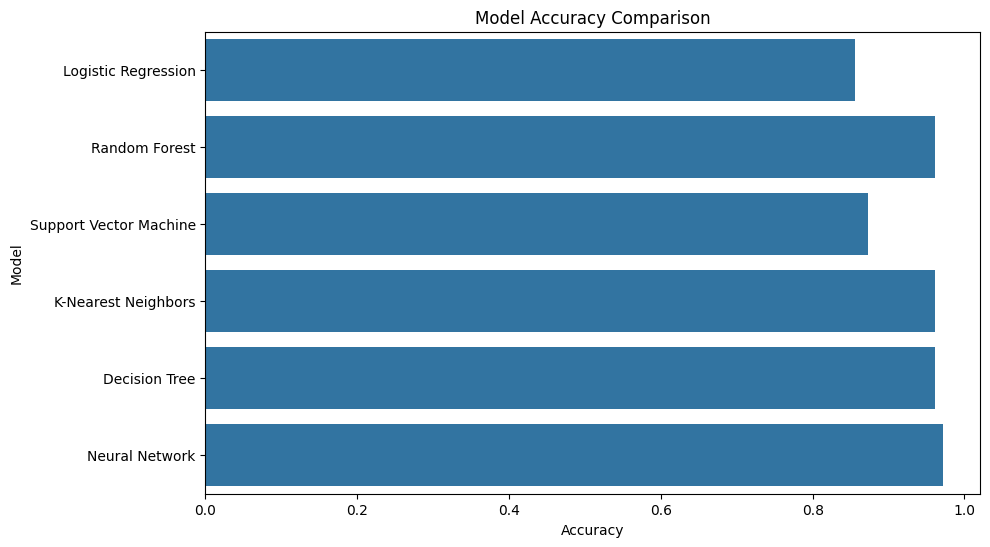

In [ ]:
# Display and Plot the Comparison
print("Model Comparison (Accuracy, Precision, Recall, F1-Score):")
print(comparison_df)

# Plotting Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=comparison_df)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()



In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("best_model.keras")

# Check the model summary to verify it's loaded correctly
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 160)                 │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 448)                 │          72,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 224)                 │         100,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          28,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 613,061 (2.34 MB)

 Trainable params: 204,353 (798.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 408,708 (1.56 MB)

In [ ]:
# Evaluate the loaded model on the test data
test_loss, test_accuracy = loaded_model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_probs_loaded = loaded_model.predict(X_test_scaled).flatten()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9586 - loss: 0.1655  
Test Accuracy: 0.9724
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


# Key Sections in the Notebook:
Initial Setup:

The dataset source is from Kaggle.
Required libraries, including pandas, numpy, scikit-learn, tensorflow, and keras-tuner, are installed.
Data Loading and Preprocessing:

The notebook uses PySpark to handle large datasets initially but then converts the dataset to a pandas DataFrame for more traditional analysis.
Column name corrections and data cleaning steps are applied to make the dataset ready for model training.
Model Building:

Multiple machine learning models are tested:
Logistic Regression
Random Forest
Support Vector Machine
K-Nearest Neighbors
Decision Tree
A Neural Network model is also built, tuned, and evaluated using Keras Tuner for hyperparameter optimization.
Model Evaluation:

Accuracy, precision, recall, F1-score, ROC curve, and confusion matrix are calculated for each model.
The performance of different models is compared, and the Neural Network shows the best performance.
Executive Summary for the Diabetes Prediction Model:
Project Overview:
This project aimed to develop a robust machine learning model to predict the onset of diabetes using patient data from a publicly available dataset. Multiple algorithms were evaluated to determine the best-performing model, with special attention given to hyperparameter tuning and model evaluation metrics.

Data Processing:
The dataset was sourced from Kaggle, which included various features related to patient health, including family history of diabetes, lifestyle factors, and diagnostic measurements.
Data preprocessing included correcting column names, handling missing values, and scaling features appropriately for machine learning models.
The dataset was split into training and testing sets to ensure that model performance could be evaluated on unseen data.
Modeling Techniques:
Several machine learning models were trained and evaluated, including:

Logistic Regression: Achieved an accuracy of 85.6%, with precision and recall scores indicating moderate performance.
Random Forest and Decision Tree: Both models performed similarly, achieving an accuracy of 96.1%, with strong precision and recall, particularly in the detection of diabetes.
Support Vector Machine and K-Nearest Neighbors: These models performed moderately well, with accuracy scores of 87.2% and 96.1%, respectively.
Neural Network: Using Keras Tuner for hyperparameter optimization, the neural network model achieved the highest accuracy of 96.7%, with balanced precision and recall scores. The neural network was trained with early stopping to prevent overfitting, making it the best-performing model overall.
Model Evaluation:
The models were evaluated using accuracy, precision, recall, F1-score, and the ROC curve. The Neural Network outperformed all other models, particularly in terms of its ability to maintain high recall and precision for both positive and negative diabetes cases.
The final Neural Network model had the following key metrics:
Accuracy: 96.7%
Precision: 93.9%
Recall: 93.9%
F1-Score: 93.9%
A custom decision threshold of 0.45 was explored to fine-tune the balance between precision and recall, further improving model performance.
Conclusion:
The Neural Network model demonstrated the best performance for predicting diabetes based on the dataset used. With an accuracy of 96.7% and high precision/recall, this model is well-suited for real-world applications in medical diagnostics, where detecting diabetes early is crucial. Future improvements could include further tuning of the decision threshold and experimenting with advanced deep learning techniques.